# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．



In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/'My Drive'/annd/nlp

/content/drive/My Drive/annd/nlp


## 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$x_i$を並べた行列$X$と，正解ラベルを並べた行列（ベクトル）$Y$を作成したい．

$$
X = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \dots \\ 
  \boldsymbol{x}_n \\ 
\end{pmatrix} \in \mathbb{R}^{n \times d},
Y = \begin{pmatrix} 
  y_1 \\ 
  y_2 \\ 
  \dots \\ 
  y_n \\ 
\end{pmatrix} \in \mathbb{N}^{n}
$$

ここで，$n$は学習データの事例数であり，$x_i \in Rdとy_i \in N$はそれぞれ，$i \in {1,…,n}$番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．$N < 4$で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベル$yi$は$yi \in N < 4$で表現できる． 以降では，ラベルの種類数を$L$で表す（今回の分類タスクでは$L=4$である）．

i番目の事例の特徴ベクトル$x_i$は，次式で求める．

$$
\boldsymbol{x}_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})
$$

ここで，i番目の事例は$T_i$個の（記事見出しの）単語列$(wi,1,wi,2,…,wi,Ti)$から構成され，$emb(w) \in Rd$は単語$w$に対応する単語ベクトル（次元数は$d$）である．すなわち，$i$番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$x_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，$d=300$である．

i番目の事例のラベル$y_i$は，次のように定義する．

$$
% <![CDATA[
y_i = \begin{cases}
0 & (\mbox{記事}x_i\mbox{が「ビジネス」カテゴリの場合}) \\
1 & (\mbox{記事}x_i\mbox{が「科学技術」カテゴリの場合}) \\
2 & (\mbox{記事}x_i\mbox{が「エンターテイメント」カテゴリの場合}) \\
3 & (\mbox{記事}x_i\mbox{が「健康」カテゴリの場合}) \\
\end{cases} %]]>
$$

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

- 学習データの特徴量行列: $X_{train} \in R^{N_t * d}$
- 学習データのラベルベクトル: $Y_{train} \in N^{N_t}$
- 検証データの特徴量行列: $X_{valid} \in R^{N_v * d}$
- 検証データのラベルベクトル: $Y_{valid} \in N^{N_v}$
- 評価データの特徴量行列: $X_{test} \in R^{N_e * d}$
- 評価データのラベルベクトル: $Y_{test} \in N^{N_e}$

なお，$N_t,N_v,N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [0]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train_txt', sep='\t')
df_valid = pd.read_csv('valid_txt', sep='\t')
df_test = pd.read_csv('test_txt', sep='\t')

In [0]:
import re
import string
category={'b' : 0, 't' : 1, 'e' : 2, 'm' :3 }

def clean_text(s):
    s = s.lower()
    for ch in string.punctuation:                                                                                     
        s = s.replace(ch, " ")
    s = re.sub(' +',' ', s)  
    return s

def sent_to_vector(sent):
    lst = [torch.tensor(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return torch.stack([sent_to_vector(x) for x in dataset])


In [0]:
train_x = df_train['Title'].map(clean_text).tolist()
train_x = [t.split() for t in train_x]
train_y = df_train['Category'].map(category).tolist()
valid_x = df_valid['Title'].map(clean_text).tolist()
valid_x = [t.split() for t in valid_x]
valid_y = df_valid['Category'].map(category).tolist()
test_x = df_test['Title'].map(clean_text).tolist()
test_x = [t.split() for t in test_x]
test_y = df_test['Category'].map(category).tolist()

In [7]:
import torch
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_y = torch.tensor(train_y).long()
valid_y = torch.tensor(valid_y).long()
test_y = torch.tensor(test_y).long()

## 71. 単層ニューラルネットワークによる予測

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$
\hat{\boldsymbol{y}}_1 = {\rm softmax}(\boldsymbol{x}_1 W), \\
\hat{Y} = {\rm softmax}(X_{[1:4]} W)
$$

ただし，softmaxはソフトマックス関数，$X[1:4] \in R^{4 * d}$は特徴ベクトル$x1,x2,x3,x4$を縦に並べた行列である．

$$
X_{[1:4]} = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \boldsymbol{x}_3 \\ 
  \boldsymbol{x}_4 \\ 
\end{pmatrix}
$$

行列$W \in R^{d * L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$y^1 \in N^L$は未学習の行列Wで事例x1を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，$\hat Y \in N^{n*L}$は，学習データの事例$x1,x2,x3,x4$について，各カテゴリに属する確率を行列として表現している．

In [0]:
class SinglerayerModel(torch.nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(v_size, c_size, bias = False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        

    def forward(self, x):
        x = self.fc1(x)
        return x

In [11]:
model = SinglerayerModel(300,4)
x = model(train_v[:4])
x = torch.softmax(x, dim=-1)
x

tensor([[0.2477, 0.2480, 0.2537, 0.2506],
        [0.2421, 0.2475, 0.2330, 0.2774],
        [0.2448, 0.2406, 0.2695, 0.2452],
        [0.2455, 0.2420, 0.2675, 0.2450]], grad_fn=<SoftmaxBackward>)

## 72. 損失と勾配の計算

学習データの事例x1と事例集合$x1,x2,x3,x4$に対して，クロスエントロピー損失と，行列$W$に対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．

$$
li=−log[事例xiがyiに分類される確率]
$$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [13]:
v = model(train_v[:4])
y = train_y[:4]
loss = criterion(v, y)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc1.weight.grad)

損失 : 1.4100003242492676
勾配
tensor([[-0.0047,  0.0098,  0.0091,  ..., -0.0093,  0.0025,  0.0043],
        [ 0.0040, -0.0014, -0.0018,  ..., -0.0159,  0.0021,  0.0096],
        [-0.0037, -0.0068, -0.0055,  ...,  0.0423, -0.0069, -0.0241],
        [ 0.0043, -0.0016, -0.0019,  ..., -0.0171,  0.0023,  0.0101]])


In [14]:
model(train_v[:4])

tensor([[ 0.0030,  0.0043,  0.0270,  0.0148],
        [ 0.0014,  0.0234, -0.0368,  0.1375],
        [ 0.0081, -0.0092,  0.1044,  0.0097],
        [-0.0115, -0.0261,  0.0740, -0.0136]], grad_fn=<MmBackward>)

## 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列$W$を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）

In [0]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super(Dataset, self).__init__()
        self.x = x
        self.y = y
        self.size = len(x)

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return (x, y)

In [0]:
train_dataset = Dataset(x = train_v, y= train_y)

In [0]:
batch_size = 6
EPOCHS = 50

In [0]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SinglerayerModel(
  (fc1): Linear(in_features=300, out_features=4, bias=False)
)

In [23]:
model.train()
avg_acc = 0
train_losses = []
valid_losses = []
y_preds = []
tra_correct_rate = []
val_correct_rate = []

for epoch in range(EPOCHS):
        for i, (x, y) in enumerate(train_dataloader):
            y_pred = model(x.to(device))
            loss = criterion(y_pred.to(device), y.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
            print('\rEpoch: %d/%d, %f%% loss: %0.2f'% (epoch+1, EPOCHS, i/len(train_dataloader)*100, loss.item()), end='')
            acc = accuracy(y.cpu().numpy(), torch.max(y_pred.data, 1)[1].cpu().detach().numpy().squeeze())
            avg_acc += acc
        train_losses.append(loss.item())
        tra_correct_rate.append(avg_acc / len(train_dataloader))
        avg_acc = 0
        for i, (x, y) in enumerate(valid_dataloader):

            y_pred = model(x.to(device))
            loss = criterion(y_pred.to(device),  y.to(device))
            acc = accuracy(y.cpu().numpy(), torch.max(y_pred.data, 1)[1].cpu().detach().numpy().squeeze())
            avg_acc += acc
            print('\r%0.2f%% loss: %0.2f, accuracy %0.2f'% (i/len(valid_dataloader)*100, loss.item(), acc), end='')
        valid_losses.append(loss.item())
        val_correct_rate.append(avg_acc / len(valid_dataloader))
        avg_acc = 0
        """torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            }, '/checkpoint')
        """
        print()

99.55% loss: 0.81, accuracy 1.00
99.55% loss: 1.00, accuracy 0.50
99.55% loss: 0.23, accuracy 1.00
99.55% loss: 1.08, accuracy 0.50
99.55% loss: 0.74, accuracy 0.50
99.55% loss: 0.05, accuracy 1.00
99.55% loss: 1.19, accuracy 0.50
99.55% loss: 0.30, accuracy 1.00
99.55% loss: 0.04, accuracy 1.00
99.55% loss: 0.12, accuracy 1.00
99.55% loss: 0.03, accuracy 1.00
99.55% loss: 1.78, accuracy 0.50
99.55% loss: 0.09, accuracy 1.00
99.55% loss: 1.94, accuracy 0.50
99.55% loss: 0.20, accuracy 1.00
99.55% loss: 0.96, accuracy 0.50
99.55% loss: 0.01, accuracy 1.00
99.55% loss: 0.25, accuracy 1.00
99.55% loss: 0.01, accuracy 1.00
99.55% loss: 0.19, accuracy 1.00
99.55% loss: 0.05, accuracy 1.00
99.55% loss: 0.29, accuracy 1.00
99.55% loss: 0.07, accuracy 1.00
99.55% loss: 0.54, accuracy 1.00
99.55% loss: 0.08, accuracy 1.00
99.55% loss: 0.09, accuracy 1.00
99.55% loss: 0.03, accuracy 1.00
99.55% loss: 0.06, accuracy 1.00
99.55% loss: 0.29, accuracy 1.00
99.55% loss: 0.01, accuracy 1.00
99.55% los

## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [0]:
valid_dataset = Dataset(x = valid_v, y= valid_y)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

In [0]:
def accuracy(y_actual, y_pred):
    return np.sum(y_actual == y_pred).astype('int') / y_actual.shape[0]

In [25]:
model.eval()
avg_acc = 0
losses = []
for i, (x, y) in enumerate(valid_dataloader):

    y_pred = model(x.to(device))
    loss = criterion(y_pred.to(device),  y.to(device))
    acc = accuracy(y.cpu().numpy(), torch.max(y_pred.data, 1)[1].cpu().detach().numpy().squeeze())
    avg_acc += acc
    print('\r%0.2f%% loss: %0.2f, accuracy %0.2f'% (i/len(valid_dataloader)*100, loss.item(), acc), end='')
    losses.append(loss.item())
print('\nAverage accuracy: ', avg_acc / len(valid_dataloader))

99.55% loss: 0.00, accuracy 1.00
Average accuracy:  0.8998505231689089


In [0]:
test_dataset = Dataset(x = test_v, y= test_y)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [0]:
model.eval()
avg_acc = 0
for i, (x, y) in enumerate(test_dataloader):

    y_pred = model(x)
    loss = criterion(y_pred,  y)
    acc = accuracy(y.numpy(), torch.max(y_pred.data, 1)[1].detach().numpy().squeeze())
    avg_acc += acc
    print('\r%0.2f%% loss: %0.2f, accuracy %0.2f'% (i/len(test_dataloader)*100, loss.item(), acc), end='')
print('\nAverage accuracy: ', avg_acc / len(test_dataloader))

99.55% loss: 0.60, accuracy 0.50
Average accuracy:  0.8871449925261589


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

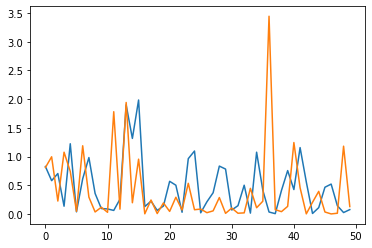

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)


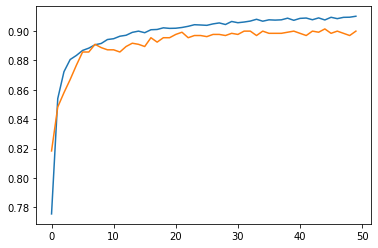

In [27]:
plt.plot(tra_correct_rate)
plt.plot(val_correct_rate)

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ

## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列$W$の値を更新せよ（ミニバッチ化）．Bの値を$1,2,4,8,…$と変化させながら，1エポックの学習に要する時間を比較せよ．

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [0]:
class MultirayerModel(torch.nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(v_size, 10, bias = False)
        self.fc2 = torch.nn.Linear(10, 7)
        self.fc3 = torch.nn.Linear(7, c_size)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [0]:
model = MultirayerModel(300,4)

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [32]:
model.train()
avg_acc = 0
train_losses = []
valid_losses = []
y_preds = []
tra_correct_rate = []
val_correct_rate = []

for epoch in range(EPOCHS):
        for i, (x, y) in enumerate(train_dataloader):
            y_pred = model(x.to(device))
            loss = criterion(y_pred.to(device), y.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
            print('\rEpoch: %d/%d, %f%% loss: %0.2f'% (epoch+1, EPOCHS, i/len(train_dataloader)*100, loss.item()), end='')
            acc = accuracy(y.cpu().numpy(), torch.max(y_pred.data, 1)[1].cpu().detach().numpy().squeeze())
            avg_acc += acc
        train_losses.append(loss.item())
        tra_correct_rate.append(avg_acc / len(train_dataloader))
        avg_acc = 0
        for i, (x, y) in enumerate(valid_dataloader):

            y_pred = model(x.to(device))
            loss = criterion(y_pred.to(device),  y.to(device))
            acc = accuracy(y.cpu().numpy(), torch.max(y_pred.data, 1)[1].cpu().detach().numpy().squeeze())
            avg_acc += acc
            print('\r%0.2f%% loss: %0.2f, accuracy %0.2f'% (i/len(valid_dataloader)*100, loss.item(), acc), end='')
        valid_losses.append(loss.item())
        val_correct_rate.append(avg_acc / len(valid_dataloader))
        avg_acc = 0
        """torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            }, '/checkpoint')
        """
        print()

99.55% loss: 0.03, accuracy 1.00
99.55% loss: 0.01, accuracy 1.00
99.55% loss: 0.25, accuracy 1.00
99.55% loss: 0.02, accuracy 1.00
99.55% loss: 0.04, accuracy 1.00
99.55% loss: 0.18, accuracy 1.00
99.55% loss: 0.06, accuracy 1.00
99.55% loss: 0.01, accuracy 1.00
99.55% loss: 0.03, accuracy 1.00
99.55% loss: 0.02, accuracy 1.00
99.55% loss: 0.00, accuracy 1.00
99.55% loss: 0.49, accuracy 0.50
99.55% loss: 0.00, accuracy 1.00
99.55% loss: 0.03, accuracy 1.00
99.55% loss: 0.00, accuracy 1.00
99.55% loss: 0.14, accuracy 1.00
99.55% loss: 0.10, accuracy 1.00
99.55% loss: 0.05, accuracy 1.00
99.55% loss: 0.11, accuracy 1.00
99.55% loss: 0.01, accuracy 1.00
99.55% loss: 0.73, accuracy 0.50
99.55% loss: 0.06, accuracy 1.00
99.55% loss: 0.02, accuracy 1.00
99.55% loss: 0.04, accuracy 1.00
99.55% loss: 0.12, accuracy 1.00
99.55% loss: 0.06, accuracy 1.00
99.55% loss: 2.34, accuracy 0.50
99.55% loss: 0.03, accuracy 1.00
99.55% loss: 0.91, accuracy 0.50
99.55% loss: 0.04, accuracy 1.00
99.55% los

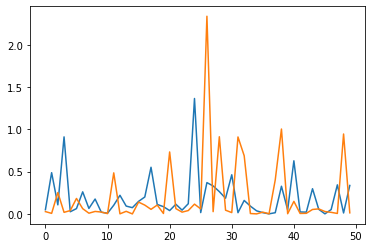

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

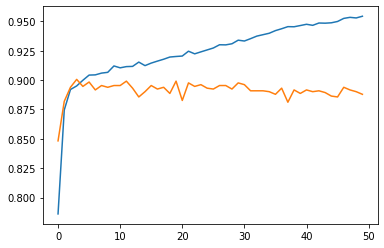

In [34]:
plt.plot(tra_correct_rate)
plt.plot(val_correct_rate)

In [39]:
val_correct_rate[3]

0.9005979073243652